# Monte Carlo simulation for computing $\pi$

$$
\frac{1}{N}\sum^N_{i=1}\mathbf{1}_{\{X_{1,i}^2+X_{2,i}^2\le 1\}}
$$

In [1]:
import torch
import math
N = 2**20
X = torch.rand(N,2)

samp = 4.0*((X*X).sum(dim=1)<1)
Ihat,s = samp.mean(), samp.var()
print(f"Estimate: {Ihat:.4f}±{math.sqrt(s/N):.4f}")

Estimate: 3.1392±0.0016


# Importance sampling example

### No, IS large variance
Let $X\sim \mathcal{N}(0,1)$. Estimate
$$
\mathbb{P}(X>3)=0.00135
$$
with the estimator
$$
\hat{I}_N=\frac{1}{N}\sum^N_{i=1}\mathbf{1}_{\{X_i>3\}}
$$

In [2]:
import torch
import math
N = 2**10
X = torch.normal(0,1,size=(N,1))

samp = (X>3).float()
Ihat,s = samp.mean(), samp.var()
print(f"Estimate: {Ihat:.5f}±{math.sqrt(s/N):.5f}")

Estimate: 0.00293±0.00169


### IS, small variance

Let $X\sim \mathcal{N}(0,1)$. Estimate
$$
\mathbb{P}(X>3)=0.00135
$$
with the estimator
$$
\hat{I}_N=
\frac{1}{N}\sum^N_{i=1}\mathbf{1}_{\{Y_i>3\}}\left(\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{Y_i^2}{2}\right)\right)/
\left(\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{(Y_i-3)^2}{2}\right)\right)\\
=
\frac{1}{N}\sum^N_{i=1}\exp\left(\frac{(Y_i-3)^2-Y_i^2}{2}\right)
\mathbf{1}_{\{Y_i>3\}}
$$
where $Y_i\sim \mathcal{N}(3,1)$. This importance sampled estimator has a far smaller variance.

In [3]:
import torch
import math
N = 2**10
Y = torch.normal(3,1,size=(N,1))
samp = ((Y>3)*torch.exp(((Y-3)**2-Y**2)/2))
Ihat,s = samp.mean(), samp.var()
print(f"Estimate: {Ihat:.5f}±{math.sqrt(s/N):.5f}")

Estimate: 0.00132±0.00008


#### why $Y_i\sim \mathcal{N}(3,1)$ ?

as optimal sampling distribution 
$g(x) = \frac{\phi(x)f(x)}{I}$ , here $\phi(x) = \mathbf{1}_{x>3}$ and $I = 0.00135$
$$
$$


# Log-derivative trick example

$$ \nabla_{\theta}\mathbb{E}_{X~f_{\theta}}[\phi(X)] = \nabla_{\theta}\int{\phi(x)f_{\theta}(x)dx} 
= \int{\phi(x)\nabla_{\theta}f_{\theta}(x)dx} 
= \int{\phi(x)\frac{\nabla_{\theta}f_{\theta}(x)}{f_{\theta}(x)}f_{\theta}(x)dx} 
= \mathbb{E}_{X~f_{\theta}}[\phi(x)\nabla_{\theta}log(f_{\theta}(X)]$$

In [21]:
import torch
import math

c = torch.tensor([[5.,5.]])
mu = torch.tensor([[0.,0.]])
lr = 1e-2
B = 16
iterations = 50  #not epochs, iterations
history1 = torch.zeros((iterations+1, 2))

for itr in range(iterations):
    X = torch.normal(0,1,size=(B,2)) + mu
    g = torch.sum(torch.sum((X - c)**2,dim=1).unsqueeze(1)*(X-mu),dim=0)
    mu -= lr*g
    # save history
    history1[itr+1] = mu
    
print(mu)

tensor([[4.8041, 5.0064]])


# Reparameterization trick example

In [22]:
import torch
import math

c = torch.tensor([[5.,5.]])
mu = torch.tensor([[0.,0.]])
lr = 1e-2
B = 16
iterations = 50
history2 = torch.zeros((iterations+1, 2))

for itr in range(iterations):
    Y = torch.normal(0,1,size=(B,2))
    g = torch.sum(Y+mu-c,dim=0)
    mu -= lr*g
    # save history
    history2[itr+1] = mu    
    
print(mu)

tensor([[4.9931, 5.0690]])


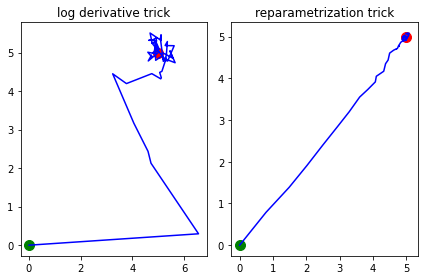

In [23]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

x1 = np.array(history1[:, 0])
y1 = np.array(history1[:, 1])

x2 = np.array(history2[:, 0])
y2 = np.array(history2[:, 1])

plt.subplot(1, 2, 1)
plt.scatter(0,0, s=100, c='green')
plt.scatter(c[0][0],c[0][1], s=100, c='red')
plt.plot(x1, y1, linestyle='solid',color='blue')
plt.title('log derivative trick')

plt.subplot(1, 2, 2)
plt.scatter(0,0, s=100, c='green')
plt.scatter(c[0][0],c[0][1], s=100, c='red')
plt.plot(x2, y2, linestyle='solid',color='blue')
plt.title('reparametrization trick')

plt.tight_layout()
plt.show()
#plt.savefig('derivative_trick.png')